In [1]:
! pip install langgraph langchain_core langchain langchain_groq langchain-google-genai

In [8]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI

from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv
from google.colab import userdata
GROQ_API_KEY = userdata.get('GROQ_API_KEY')

In [9]:
class State(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str

In [10]:
MODEL = "llama-3.1-8b-instant"
def categorize(state: State) -> State:
    """For categorize the customer queries into Technical issue, Billing issue, or General issue."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories: "
        "Technical, Billing, General. Query: {query} by the users query "
    )
    chain = prompt | ChatGroq(model=MODEL, temperature=0 , api_key=GROQ_API_KEY)
    category = chain.invoke({"query": state["query"]}).content
    return {"category": category}

def analyze_sentiment(state: State) -> State:
    """Sentiment Analysis"""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer sentiment classifying the query. "
        "Respond with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
    )
    chain = prompt | ChatGroq(model=MODEL, temperature=0,api_key=GROQ_API_KEY)
    sentiment = chain.invoke({"query": state["query"]}).content
    return {"sentiment": sentiment}

def handle_technical(state: State) -> State:
    """Provide a technical support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a technical support response to the following query: {query}"
    )
    chain = prompt | ChatGroq(model=MODEL, temperature=0,api_key=GROQ_API_KEY)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_billing(state: State) -> State:
    """Provide a billing support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a billing support response to the following query: {query}"
    )
    chain = prompt | ChatGroq(model=MODEL, temperature=0,api_key=GROQ_API_KEY)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_general(state: State) -> State:
    """Provide a general support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query: {query}"
    )
    chain = prompt | ChatGroq(model=MODEL, temperature=0,api_key=GROQ_API_KEY)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def to_human_agent(state: State) -> State:
    """Escalate the query to a human agent due to negative sentiment."""
    return {"response": "This query has been escalated to a human agent due to its negative sentiment."}

def route_query(state: State) -> str:
    """Route the query based on its sentiment and category."""
    if state["sentiment"] == "Negative":
        return "escalate"
    elif state["category"] == "Technical":
        return "handle_technical"
    elif state["category"] == "Billing":
        return "handle_billing"
    else:
        return "handle_general"

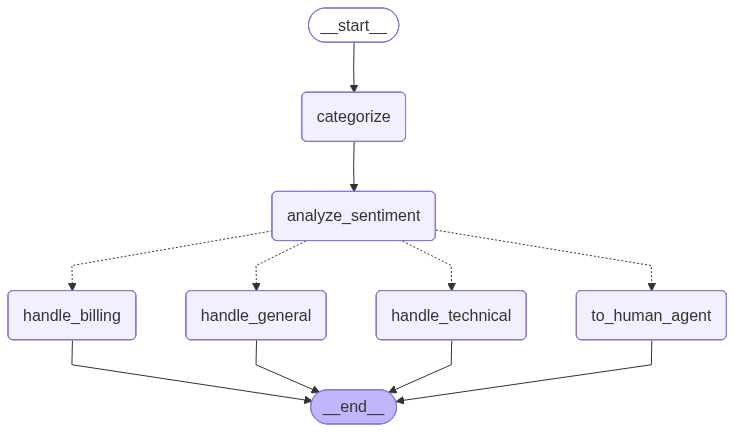

In [11]:

graph_builder = StateGraph(State)


graph_builder.add_node("categorize", categorize)
graph_builder.add_node("analyze_sentiment", analyze_sentiment)
graph_builder.add_node("handle_technical", handle_technical)
graph_builder.add_node("handle_billing", handle_billing)
graph_builder.add_node("handle_general", handle_general)
graph_builder.add_node("to_human_agent", to_human_agent)


graph_builder.add_edge("categorize", "analyze_sentiment")
graph_builder.add_conditional_edges(
    "analyze_sentiment",
    route_query,
    {
        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing",
        "handle_general": "handle_general",
        "to_human_agent": "to_human_agent"
    }
)
graph_builder.add_edge("handle_technical", END)
graph_builder.add_edge("handle_billing", END)
graph_builder.add_edge("handle_general", END)
graph_builder.add_edge("to_human_agent", END)


graph_builder.set_entry_point("categorize")


app = graph_builder.compile()
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [12]:
def run_customer_support(query: str) -> Dict[str, str]:
    """Process a customer query through the LangGraph workflow.

    Args:
        query (str): The customer's query

    Returns:
        Dict[str, str]: A dictionary containing the query's category, sentiment, and response
    """
    results = app.invoke({"query": query})
    return {
        "category": results["category"],
        "sentiment": results["sentiment"],
        "response": results["response"]
    }

In [16]:
queries =["My Samsung S25 's Camera is not working properly , Can i get help to recover my camera? ","I need some Help"
          "where can i find nearest service center in Hyderabad?","What are your Working hours can i visit now?"
          ]
for query in queries:
  result = run_customer_support(query)
  print(f"Query: {query}")
  print(f"Category: {result['category']}")
  print(f"Sentiment: {result['sentiment']}")
  print(f"Response: {result['response']}")
  print("\n")


Query: My Samsung S25 's Camera is not working properly , Can i get help to recover my camera? 
Category: I would categorize the customer query as "Technical". 

The query is related to a specific issue with a product (Samsung S25's camera) and the customer is seeking assistance to resolve the problem, which falls under technical support.
Sentiment: The sentiment of this customer query is 'Negative'. The customer is experiencing an issue with their Samsung S25's camera and is seeking help to resolve the problem, indicating frustration or dissatisfaction with the product's performance.
Response: I'd be happy to help you troubleshoot the issue with your Samsung S25's camera. Here are some general steps you can try to recover your camera:

1. **Restart your phone**: Sometimes, a simple reboot can resolve the issue. Press and hold the power button until your phone shuts down, then turn it back on.
2. **Check for software updates**: Ensure your phone's software is up to date, as newer versi